稠密连接网络（DenseNet）

ResNet极大地改变了如何参数化深层网络中函数的观点。 稠密连接网络（DenseNet） (Huang et al., 2017)在某种程度上是ResNet的逻辑扩展。让我们先从数学上了解一下。

从ResNet到DenseNet

回想一下任意函数的泰勒展开式（Taylor expansion），它把这个函数分解成越来越高阶的项。在x接近0时，  
$$f(x)=f(0)+f'(0)x+ \frac{f''(0)}{2!}x^2+...$$
同样，ResNet将函数展开为  
$$f(x)=x+g(x)$$
也就是说，ResNet将f分解为两部分：一个简单的线性项和一个复杂的非线性项。   
那么再向前拓展一步，如果我们想将f拓展成超过两部分的信息呢？ 一种方案便是DenseNet。  
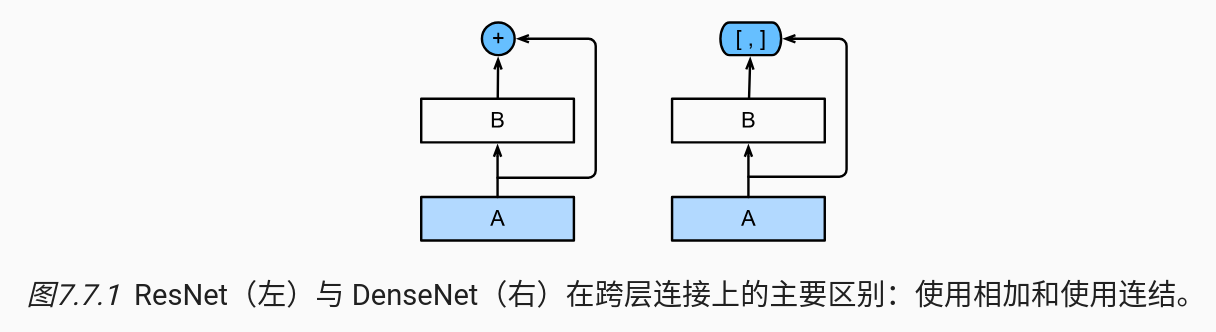

如 图7.7.1所示，ResNet和DenseNet的关键区别在于，DenseNet输出是连接（用图中的表示）而不是如ResNet的简单相加。  
因此，在应用越来越复杂的函数序列后，我们执行从x到其展开式的映射：  
$$x-->[x,f_1(x),f_2([x,f_1(x)]),f_3([x,f_1(x),f_2([x,f_1(x)])])]$$
最后，将这些展开式结合到多层感知机中，再次减少特征的数量。  
实现起来非常简单：我们不需要添加术语，而是将它们连接起来。  
DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。 稠密连接如 图7.7.2所示。  
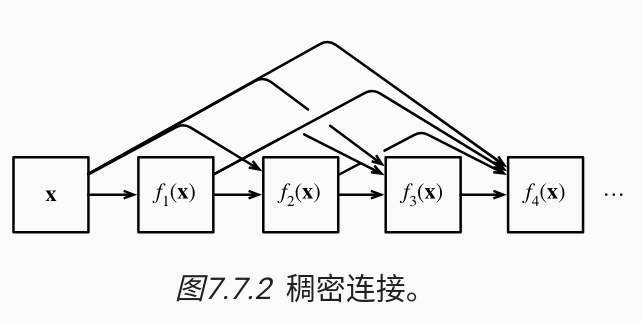  
稠密网络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。  
前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

稠密块体

DenseNet使用了ResNet改良版的“批量规范化、激活和卷积”架构（参见 7.6节中的练习）。 我们首先实现一下这个架构。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
#(in_size-(k-1)+2*p+s-1)/s=in_size


一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。 然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X


在下面的例子中，我们定义一个有2个输出通道数为10的DenseBlock。  
使用通道数为3的输入时，我们会得到通道数为3+2*10=23的输出。  
卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率（growth rate）。

In [3]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape


torch.Size([4, 23, 8, 8])

过渡层

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。  
而过渡层可以用来控制模型复杂度。  
它通过1*1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [4]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))
        #(in_size-(2-1)+2*0+2-1)/2=in_size


对上一个例子中稠密块的输出使用通道数为10的过渡层。 此时输出的通道数减为10，高和宽均减半。

In [5]:
blk = transition_block(23, 10)
blk(Y).shape


torch.Size([4, 10, 4, 4])

DenseNet模型

我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。  
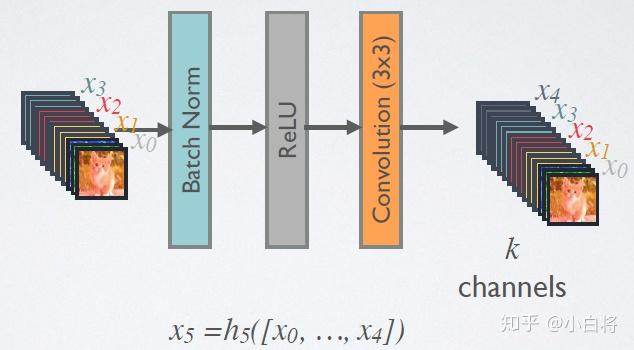

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    #(in_size-(7-1)+2*3+2-1)/2=(in_size+1)/2
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    #(in_size-(3-1)+2*1+2-1)/2=(in_size+1)/2


接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。  
与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。  
这里我们设成4，从而与 7.6节的ResNet-18保持一致。  
稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。

In [7]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2


与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。

In [8]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))


In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
DenseBlock output shape:	 torch.Size([1, 192, 56, 56])
Sequential output shape:	 torch.Size([1, 96, 28, 28])
DenseBlock output shape:	 torch.Size([1, 224, 28, 28])
Sequential output shape:	 torch.Size([1, 112, 14, 14])
DenseBlock output shape:	 torch.Size([1, 240, 14, 14])
Sequential output shape:	 torch.Size([1, 120, 7, 7])
DenseBlock output shape:	 torch.Size([1, 248, 7, 7])
BatchNorm2d output shape:	 torch.Size([1, 248, 7, 7])
ReLU output shape:	 torch.Size([1, 248, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


训练模型

由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。

train_loss 0.152,test_loss 0.403, train acc 0.945, test acc 0.852
857.3 examples/sec on cuda:0


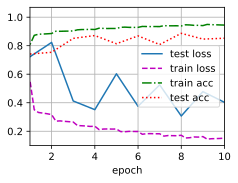

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 320
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
